# Forecasting
t<sub>0</sub> corresponds to the time at which the forecast is made (12:00 CET) for EPEX SPOT day-ahead auction.<br>

In [1]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from collections import defaultdict

from utils import tools, preprocessing, models, eval, plotting, hpo

2025-09-11 11:33:28.475371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757583208.497498 3902811 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757583208.504607 3902811 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757583208.522429 3902811 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757583208.522452 3902811 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757583208.522454 3902811 computation_placer.cc:177] computation placer alr

In [2]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.1.4
Numpy version: 1.26.4
Tensorflow version: 2.19.0


In [3]:
config = tools.load_config('configs/config_wind.yaml')
tools.initialize_gpu(7)

In [4]:
# paths
data = 'synth_wind/client_a'
key = 'synth_00161.csv'
target_col = 'power'

# model params
model_name = 'cnn-lstm'
output_dim = 48 # in hours
epochs = 20
batch_size = 16
make_callbacks = False
shuffle = True
n_cnn_layers = 10
n_rnn_layers = 1
n_layers = 2
kernel_size = 3
filters = 64
units = 64
dropout = 0.1
learning_rate = 0.0005
# fl params
strategy = 'fedavg'

# data params
freq = '1h'
lookback = 384 # in hours
horizon = 48 # in hours
step_size = output_dim
# data split params
t_0 = None#'09:00' # forecast run time (UTC)
scale_y = False
lag_in_col = False

# more params
evaluate_on_all_test_data = True
study_name = None#f'fl_a-{strategy}_d-{data}_m-{model_name}_out-{output_dim}_freq-{freq}'

In [5]:
# config related
config['data']['freq'] = freq
config['model']['name'] = model_name
config['model']['output_dim'] = output_dim
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon
config['model']['lr'] = learning_rate
config = tools.handle_freq(config=config)
freq = config['data']['freq']
output_dim = config['model']['output_dim']
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon
config['model']['step_size'] = step_size
config['data']['lag_in_col'] = lag_in_col
config['model']['rnn']['n_rnn_layers'] = n_rnn_layers
config['model']['rnn']['units'] = units
config['model']['cnn']['n_cnn_layers'] = n_cnn_layers
config['model']['cnn']['kernel_size'] = kernel_size
config['model']['cnn']['filters'] = filters
config['model']['shuffle'] = shuffle

In [6]:
# read data

known, observed, static = preprocessing.get_features(dataset_name=data, config=config)
rel_features = known + observed
dfs = preprocessing.get_data(dataset_name=data,
                             config=config,
                             data_dir='data',
                             freq=freq,
                             rel_features=rel_features)
df = dfs[key]

In [7]:
test_start = pd.Timestamp(config['data']['test_start'])
if 'lag_known_features' in config['params']:
    observed.extend(config['params']['lag_known_features'])
prepared_data, df = preprocessing.pipeline(data=df,
                                           config=config,
                                           known_cols=known,
                                           observed_cols=observed,
                                           static_cols=static,
                                           test_start=test_start,
                                           target_col=target_col)
X_train, y_train = prepared_data['X_train'], prepared_data['y_train'],
X_test, y_test = prepared_data['X_test'], prepared_data['y_test']
index_train = prepared_data['index_train']
index_test = prepared_data['index_test']
scaler_y = prepared_data['scalers']['y']
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 118080 entries, (Timestamp('2023-07-24 06:00:00+0000', tz='UTC'), 1.0, Timestamp('2023-07-24 07:00:00+0000', tz='UTC')) to (Timestamp('2025-05-03 09:00:00+0000', tz='UTC'), 48.0, Timestamp('2025-05-05 09:00:00+0000', tz='UTC'))
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   pressure_nwp           118080 non-null  float64
 1   temperature_nwp        118080 non-null  float64
 2   relhum_nwp             118080 non-null  float64
 3   power                  118080 non-null  float64
 4   wind_speed_nwp_1       118080 non-null  float64
 5   wind_speed_nwp_2       118080 non-null  float64
 6   wind_speed_nwp_3       118080 non-null  float64
 7   wind_speed_nwp_4       118080 non-null  float64
 8   wind_speed_nwp_5       118080 non-null  float64
 9   wind_speed_nwp_6       118080 non-null  float64
 10  density_nwp_1          118080 non-null  float64


In [9]:
config['model']['fl'] = False
study = hpo.load_study(config['hpo']['studies_path'], study_name)
hyperparameters = hpo.get_hyperparameters(config=config, study=study)
hyperparameters['epochs'] = epochs#config['model']['epochs']
hyperparameters['batch_size'] = batch_size#config['model']['epochs']

config['model']['name'] = model_name

config['model']['feature_dim'] = tools.get_feature_dim(X_train)
model = models.get_model(config=config,
                         hyperparameters=hyperparameters)

I0000 00:00:1757583216.444590 3902811 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46731 MB memory:  -> device: 7, name: NVIDIA RTX A6000, pci bus id: 0000:e1:00.0, compute capability: 8.6


In [10]:
hyperparameters

{'shuffle': True,
 'batch_size': 16,
 'epochs': 20,
 'lr': 0.0005,
 'filters': 64,
 'kernel_size': 3,
 'n_cnn_layers': 10,
 'increase_filters': False,
 'dropout': 0.1,
 'units': 64,
 'n_rnn_layers': 1}

In [11]:
#model.summary()

In [12]:
if make_callbacks:
    callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = hyperparameters['batch_size'],
    epochs = hyperparameters['epochs'],
    verbose = 'auto',
    callbacks = callbacks if make_callbacks else None,
    validation_data=(X_test, y_test),
    shuffle = hyperparameters['shuffle']
)
if make_callbacks:
    model = keras.models.load_model('models/best.keras')
best_epoch = np.argmin(history.history['val_loss']) + 1

Epoch 1/20


I0000 00:00:1757583220.064819 3903568 cuda_dnn.cc:529] Loaded cuDNN version 90800


128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0030 - mae: 0.0275 - r2: 0.0253 - rmse: 0.0547 - val_loss: 0.0030 - val_mae: 0.0261 - val_r2: 0.1112 - val_rmse: 0.0544
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0022 - mae: 0.0250 - r2: 0.2291 - rmse: 0.0466 - val_loss: 0.0028 - val_mae: 0.0237 - val_r2: 0.1642 - val_rmse: 0.0532
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0022 - mae: 0.0241 - r2: 0.3207 - rmse: 0.0465 - val_loss: 0.0026 - val_mae: 0.0244 - val_r2: 0.1814 - val_rmse: 0.0513
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0019 - mae: 0.0226 - r2: 0.3246 - rmse: 0.0438 - val_loss: 0.0026 - val_mae: 0.0266 - val_r2: 0.1354 - val_rmse: 0.0506
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0020 - mae: 0.0233 - r2: 0.3508 - rmse: 0.0444 - val_loss: 0.0022 - val_mae: 0.0234 - val_r2: 0.2508 - val_rmse: 0.0474
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0016 - mae: 0.0210 - r2: 0.4455 -

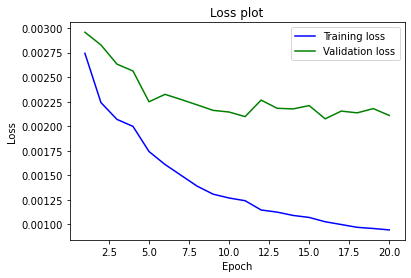

In [13]:
plotting.plot_training(history=history,
                       validation=True,
                       save_name=None)

In [14]:
y_true, y_pred = tools.get_y(X_test=X_test,
                             y_test=y_test,
                             scaler_y=scaler_y,
                             model=model)
df_pred = tools.y_to_df(y=y_pred,
                        output_dim=output_dim,
                        horizon=horizon,
                        index=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)
df_true = tools.y_to_df(y=y_true,
                        output_dim=output_dim,
                        horizon=horizon,
                        index=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

y_pers = eval.persistence(y=df[target_col],
                          horizon=horizon,
                          from_date=str(test_start.date()))
test_indices = None
if len(index_test.shape) != 1:
    test_indices = index_test[:,0]
    if output_dim == 1:
        test_indices = np.array(list(set(index_test[:,2])))
        test_indices.sort()
        y_pers = y_pers[test_indices]
        y_pers_raw = pd.DataFrame(index_test, columns=list(df.index.names))
        y_pers = y_pers_raw.merge(y_pers.to_frame(), how='left', on='timestamp')['power'].values
        test_indices = None

y_pers = preprocessing.make_windows(data=y_pers,
                                   seq_len=y_pred.shape[-1],
                                   step_size=1,
                                   indices=test_indices)

df_pers = tools.y_to_df(y=y_pers,
                        output_dim=output_dim,
                        horizon=horizon,
                        index=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

pers = {}
pers['Persistence'] = df_pers

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [15]:
results = eval.evaluate_models(pred=df_pred,
                               true=df_true,
                               persistence=pers,
                               main_model_name=model_name)

In [16]:
results

,R^2,RMSE,MAE,Skill
Models,,,,
cnn-lstm,0.400533,0.04567,0.019835,0.15801
Persistence,0.154426,0.05424,0.024615,0.00000


Forecast run at 2025-03-26 12:00:00+00:00 

R^2: -2.2708970046789507
RMSE: 0.02182884424305957
MAE: 0.010392589932821774


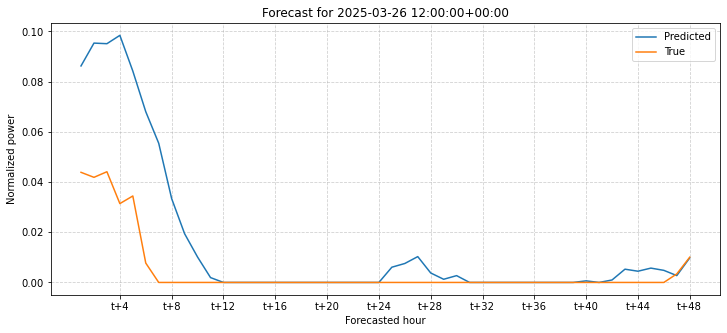

In [17]:
#date = '2025-01-04'
#datetime = pd.Timestamp(f'{date} {t_0}:00+00:00')
datetime = np.random.choice(df_pred.index)

print(f'Forecast run at {datetime}', '\n')

plotting.plot_forecast(y_pred=df_pred.loc[datetime].values,
                       y_true=df_true.loc[datetime].values,
                       horizon=horizon,
                       date=str(datetime),
                       figsize=(12,5),
                       print_metric=True,
                       grid=True)

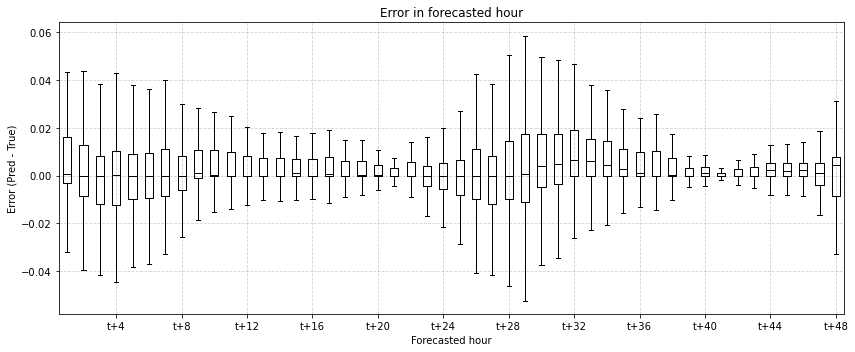

In [18]:
plotting.plot_boxplots(pred=df_pred,
                       true=df_true,
                       t_0=t_0,
                       horizon=horizon,
                       figsize=(12,5),
                       showfliers=False,
                       grid=True)

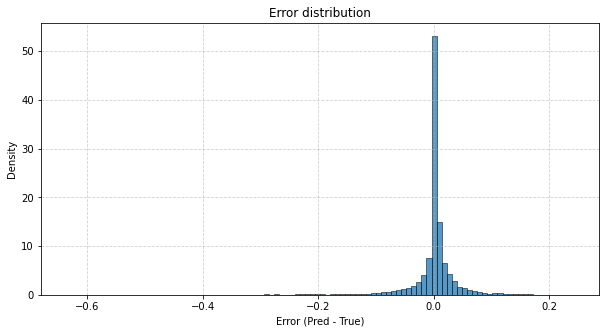

In [19]:
plotting.plot_error_distribution(pred=df_pred,
                                 true=df_true,
                                 figsize=(10,5),
                                 t_0=t_0,
                                 bins=100,
                                 grid=True)

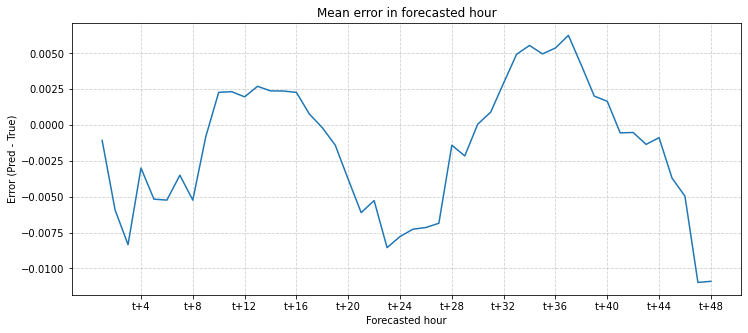

In [20]:
plotting.plot_error(pred=df_pred,
                    true=df_true,
                    t_0=t_0,
                    horizon=horizon,
                    figsize=(12,5),
                    grid=True)